In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install pandas
#!pip install numpy
#!pip install keras
#!pip install tensorflow
#!pip install transformers
#!pip install tf_keras
#!pip install torchvision

# Explainable AI Methods
#!pip install shap
#!pip install fairlearn
#!pip install lime
#!pip install shap lime interpret fairlearn
#!pip install anchor
#!pip install captum
#!pip install tf_explain
#!pip install opencv-python

In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertForSequenceClassification
import torch
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer
import shap
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from transformers import pipeline
from tensorflow.keras.models import load_model


In [4]:

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahmedma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ahmedma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ahmedma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Read the dataset
#df = pd.read_csv('LLM_Datasets/Training_Essay_Data.csv')
df = pd.read_csv('Training_Essay_Data.csv', encoding='latin1')

In [6]:

# Exploratory Data Analysis (EDA)
print(df.head())
print(df.info())
print(df['generated'].value_counts())



                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27537 entries, 0 to 27536
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27537 non-null  object
 1   generated  27537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 430.4+ KB
None
generated
0    17508
1    10029
Name: count, dtype: int64


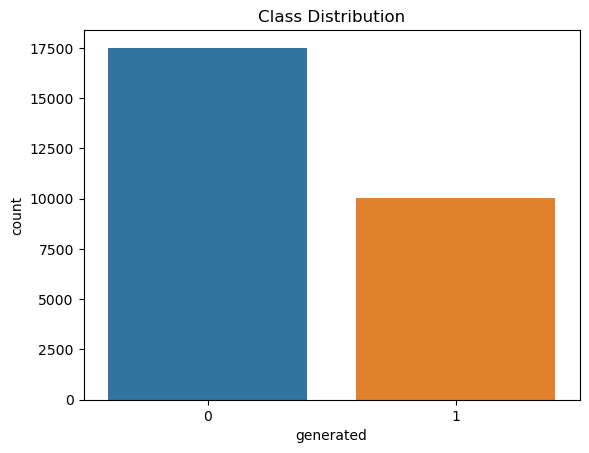

In [7]:
# Visualize class distribution
sns.countplot(x='generated', data=df)
plt.title('Class Distribution')
plt.show()


In [8]:

# Data Preprocessing and Cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text



In [9]:
df['clean_text'] = df['text'].apply(clean_text)




In [10]:
# Tokenization, stopwords removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [11]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens



In [12]:
df['tokens'] = df['clean_text'].apply(preprocess_text)



In [13]:
# Convert text data into numerical representations: TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])



In [14]:
# Define features (X) and target variable (y)
X = tfidf_matrix
y = df['generated']



In [15]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In [16]:
# Logistic Regression Model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)



LogisticRegression()

In [17]:
# Evaluate Logistic Regression model
y_pred_lr = logistic_regression_model.predict(X_test)
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Test Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2608
           1       0.99      0.98      0.98      1523

    accuracy                           0.99      4131
   macro avg       0.99      0.99      0.99      4131
weighted avg       0.99      0.99      0.99      4131



In [18]:
# Tokenize and pad text data for neural network model
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])



In [19]:
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = tf.keras.preprocessing.sequence.pad_sequences(X_seq, padding='post')



In [20]:
X_train_pad, X_temp_pad, y_train, y_temp = train_test_split(X_pad, y, test_size=0.3, random_state=42)
X_val_pad, X_test_pad, y_val, y_test = train_test_split(X_temp_pad, y_temp, test_size=0.5, random_state=42)


In [21]:
# Attention Layer Definition
class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)






In [22]:
# Define LSTM Model with Attention
def create_lstm_model(input_dim, output_dim, max_sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim, input_length=max_sequence_length))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Attention(return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    return model



In [23]:
input_dim = len(tokenizer.word_index) + 1
output_dim = 100
max_sequence_length = X_pad.shape[1]
lstm_model = create_lstm_model(input_dim, output_dim, max_sequence_length)


C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
# Train the LSTM model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = lstm_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=40, batch_size=32, callbacks=[early_stopping])


Epoch 1/40

603/603 ━━━━━━━━━━━━━━━━━━━━ 803s 1s/step - accuracy: 0.6376 - auc: 0.4993 - loss: 0.6783 - precision: 0.3704 - recall: 0.0098 - val_accuracy: 0.6357 - val_auc: 0.5000 - val_loss: 0.6593 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 791s 1s/step - accuracy: 0.6405 - auc: 0.5233 - loss: 0.6552 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6357 - val_auc: 0.6852 - val_loss: 0.6500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 764s 1s/step - accuracy: 0.6376 - auc: 0.7410 - loss: 0.6457 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6357 - val_auc: 0.6960 - val_loss: 0.6443 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 789s 1s/step - accuracy: 0.6361 - auc: 0.7639 - loss: 0.6385 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6357 - val_auc: 0.7222 - val_loss: 0.6380 - val_precision: 0.0000e

In [25]:
# Evaluate the LSTM model on the test set
y_pred_nn = (lstm_model.predict(X_test_pad) > 0.5).astype(int)
print(f"LSTM Model Test Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")
print(classification_report(y_test, y_pred_nn))

130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 221ms/step
LSTM Model Test Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2608
           1       0.99      0.99      0.99      1523

    accuracy                           0.99      4131
   macro avg       0.99      0.99      0.99      4131
weighted avg       0.99      0.99      0.99      4131



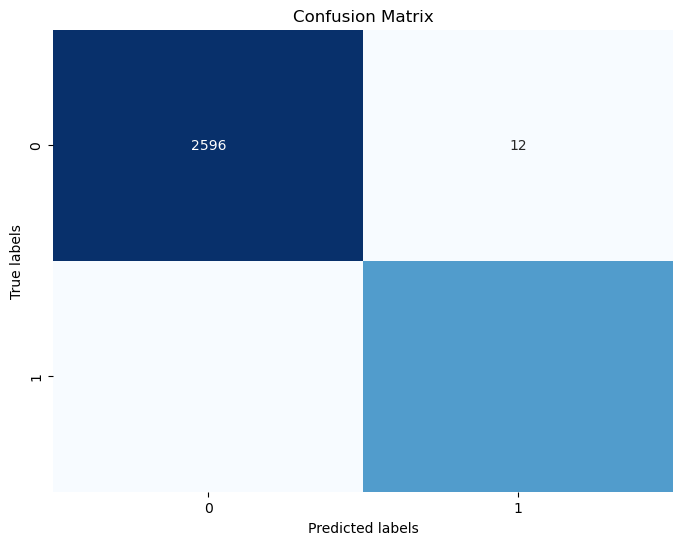

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


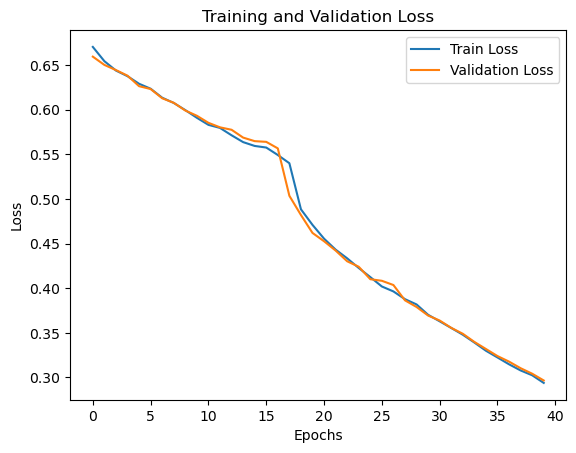

In [27]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


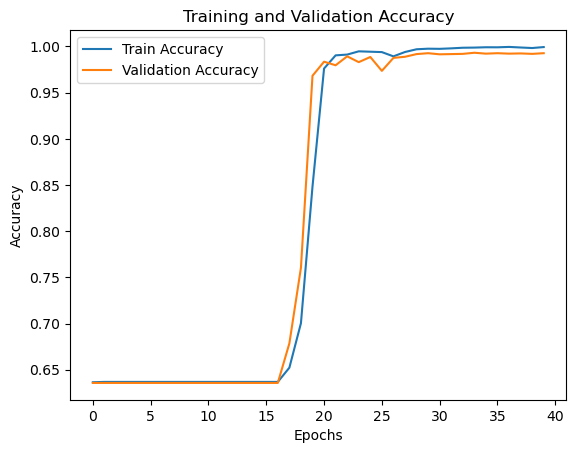

In [28]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()



In [29]:
# ROC-AUC
test_loss, test_acc, test_recall, test_precision, test_auc = lstm_model.evaluate(X_test_pad, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test AUC:", test_auc)



130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 203ms/step - accuracy: 0.9953 - auc: 0.9994 - loss: 0.2936 - precision: 0.9943 - recall: 0.9926
Test Loss: 0.29577547311782837
Test Accuracy: 0.9946743845939636
Test Recall: 0.9921311736106873
Test Precision: 0.9934340119361877
Test AUC: 0.9990968108177185


In [30]:
y_pred_proba = lstm_model.predict(X_test_pad)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)
print("Test ROC-AUC:", roc_auc_value)


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step
Test ROC-AUC: 0.9992431993683761


In [31]:
# Save the trained LSTM model
model_save_path = 'my_lstm_model.h5'
lstm_model.save(model_save_path)
print(f"Saved LSTM model at: {model_save_path}")


Saved LSTM model at: my_lstm_model.h5


In [33]:
model_save_path2 = 'my_lstm_model.keras'
lstm_model.save(model_save_path2)
print(f"Saved LSTM model at: {model_save_path2}")

Saved LSTM model at: my_lstm_model.keras


In [35]:
import keras

In [36]:
keras.saving.save_model(lstm_model, 'my_lstm_model3.keras')

In [39]:
# Load the saved LSTM model
#loaded_model = tf.keras.models.load_model('my_lstm_model3.keras')


TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 1647], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding', 'trainable': True, 'dtype': 'float32', 'input_dim': 83505, 'output_dim': 100, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 1647]}}, {'module': 'keras.layers', 'class_name': 'SpatialDropout1D', 'config': {'rate': 0.2, 'seed': None, 'name': 'spatial_dropout1d', 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [None, 1647, 100]}}, {'module': 'keras.layers', 'class_name': 'Bidirectional', 'config': {'name': 'bidirectional', 'trainable': True, 'dtype': 'float32', 'merge_mode': 'concat', 'layer': {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'forward_lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': True, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 2484500425296}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 2484500420496}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 2484500423888}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1647, 100]}}, 'backward_layer': {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'backward_lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': True, 'stateful': False, 'unroll': False, 'zero_output_for_mask': True, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 2484500402896}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 2484500409936}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 2484500403344}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1647, 100]}}}, 'registered_name': None, 'build_config': {'input_shape': [None, 1647, 100]}}, {'module': None, 'class_name': 'Attention', 'config': {'return_sequences': True, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'Attention', 'build_config': {'input_shape': [None, 1647, 128]}}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling1D', 'config': {'name': 'global_average_pooling1d', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 1647, 128]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}], 'build_input_shape': [None, 1647]}, 'registered_name': None, 'build_config': {'input_shape': [None, 1647]}, 'compile_config': {'loss': 'binary_crossentropy', 'loss_weights': None, 'metrics': ['accuracy', {'module': 'keras.metrics', 'class_name': 'Precision', 'config': {'name': 'precision', 'dtype': 'float32', 'thresholds': None, 'top_k': None, 'class_id': None}, 'registered_name': None}, {'module': 'keras.metrics', 'class_name': 'Recall', 'config': {'name': 'recall', 'dtype': 'float32', 'thresholds': None, 'top_k': None, 'class_id': None}, 'registered_name': None}, {'module': 'keras.metrics', 'class_name': 'AUC', 'config': {'name': 'auc', 'dtype': 'float32', 'num_thresholds': 200, 'curve': 'ROC', 'summation_method': 'interpolation', 'multi_label': False, 'num_labels': None, 'label_weights': None, 'from_logits': False}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: Could not locate class 'Attention'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'Attention', 'config': {'return_sequences': True, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'Attention', 'build_config': {'input_shape': [None, 1647, 128]}}

In [40]:
# SHAP
def predict_fn(X):
    return lstm_model.predict(X).flatten()



In [41]:
background = X_train_pad[:100].astype(np.float32)
explainer = shap.KernelExplainer(predict_fn, background)
shap_values = explainer.shap_values(X_test_pad[:10].astype(np.float32))



4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2573s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2591s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2502s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2504s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2591s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2573s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2646s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2638s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2492s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2592s 200ms/step


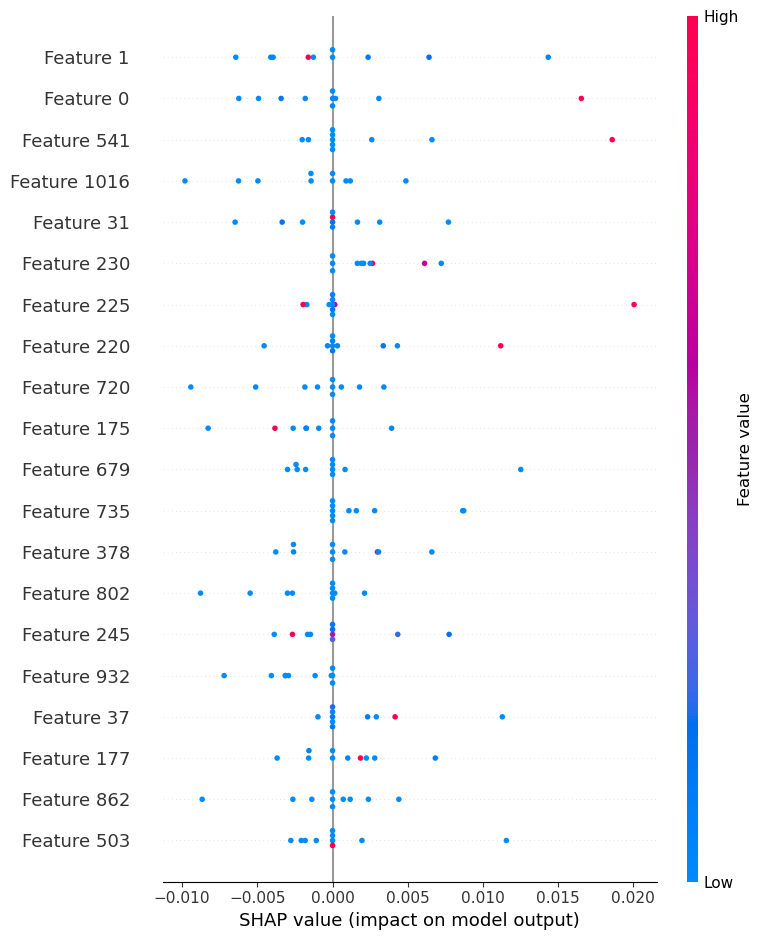

In [42]:
shap.summary_plot(shap_values, X_test_pad[:10])



In [43]:
# LIME
explainer = LimeTextExplainer(class_names=['negative', 'positive'])
idx = 0
sample_text = df['clean_text'].iloc[idx]



In [44]:
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return np.array([[1-p, p] for p in lstm_model.predict(padded).flatten()])



In [45]:
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)
exp.show_in_notebook(text=sample_text)



157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step


In [46]:
# Integrated Gradients - Explainability
ig = IntegratedGradients()
tokenizer_seq = tokenizer.texts_to_sequences(df['clean_text'])
text_input = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_seq, padding='post', maxlen=max_sequence_length)
inputs = tf.convert_to_tensor(text_input, dtype=tf.float32)
predictions = lstm_model(inputs)
explanation = ig.attribute(inputs, target=predictions[:, 0], n_steps=50)



TypeError: IntegratedGradients.__init__() missing 1 required positional argument: 'forward_func'

In [ ]:
# Visualization of Integrated Gradients
viz.visualize_text([explanation.numpy()], text_input, ['positive', 'negative'], method_name='Integrated Gradients')
plt.show()
